**This notebook borrows heavily from the following source on kaggle**

[Source article](https://www.kaggle.com/nitin194/online-store-rfm-cohort-analysis)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import datetime as dt
import os
import time

In [9]:
plt.style.use('dark_background')
mpl.rcParams['figure.figsize'] = (12, 6)

In [3]:
raw_folder = '/home/sid/mystuff/myprogs/flirt/projects/product_analytics/customer_segmentation/data/raw'

In [13]:
datapath = os.path.join(raw_folder, 'online_retail.xlsx')

In [14]:
## Import dataset
train = pd.read_excel(datapath, parse_dates=['InvoiceDate'], engine='openpyxl')

In [15]:
train.shape

(541909, 8)

In [16]:
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [19]:
## check for duplicate items
train.duplicated().sum()

5268

In [20]:
## remove duplicated items
train = train[~train.duplicated()]

In [23]:
## check for missing values
train.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [24]:
## create a list of unique InvoiceNo with null CustomerID records
Invoice_list = train[train['CustomerID'].isnull()]['InvoiceNo'].tolist()

Invoice_list

[536414,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 

In [25]:
## Check number of records with these invoice number
len(train[train.InvoiceNo.isin(Invoice_list)])

135037

In [26]:
## Removing records with null customer IDs
rfm_train = train[train['CustomerID'].notnull()].copy()

In [27]:
rfm_train.shape

(401604, 8)

In [29]:
rfm_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 103.0 MB


In [34]:
rfm_train['CustomerID'] = rfm_train['CustomerID'].astype(int)

In [35]:
rfm_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  int64         
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 103.0 MB


In [37]:
rfm_train.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### **Check for cancelled items**

In [38]:
desc_df = rfm_train[~rfm_train['InvoiceNo'].str.contains('C', na=False)]

In [53]:
## Lets create total cost feature
desc_df['Total_cost'] = rfm_train['Quantity'] * rfm_train['UnitPrice']

In [54]:
desc_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


### EDA

In [55]:
print(f'Oldest date is - {desc_df.InvoiceDate.min()}\n')
print(f'Latest date is - {desc_df.InvoiceDate.max()}')

Oldest date is - 2010-12-01 08:26:00

Latest date is - 2011-12-09 12:50:00


In [56]:
# Check the top ten countries in the dataset with highest transactions
desc_df.Country.value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Name: Country, dtype: object

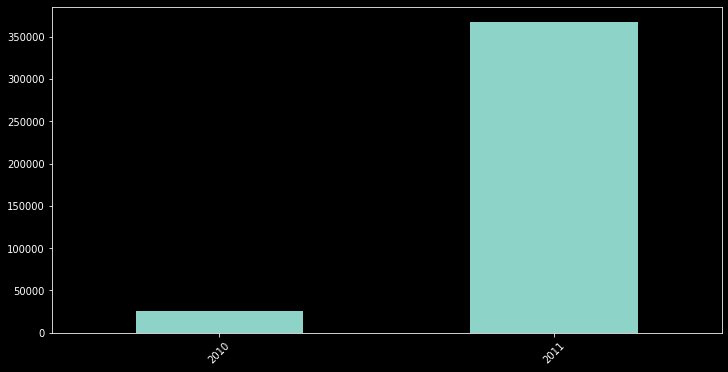

In [57]:
# Count of transactions in different years
desc_df.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar', rot=45);

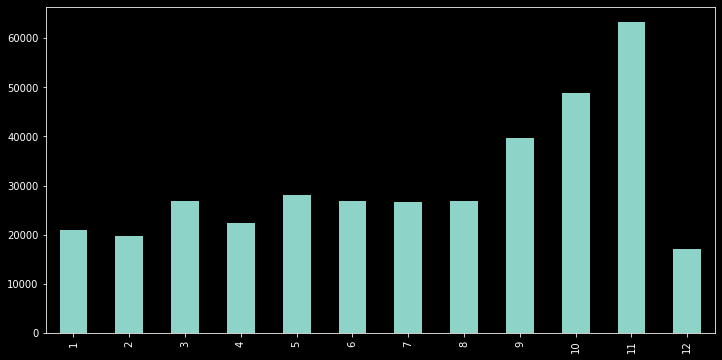

In [58]:
# Count of transactions in different months within 2011 year.
desc_df[desc_df.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar');

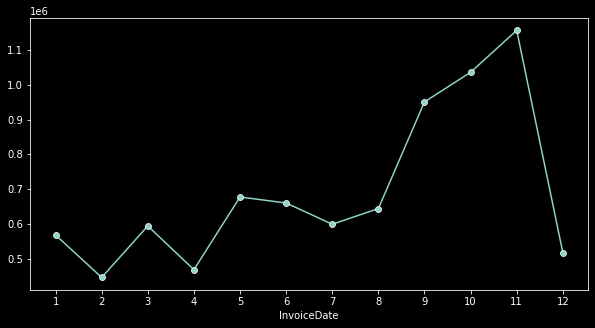

In [59]:
# Let's visualize the top grossing months
monthly_gross = desc_df[desc_df.InvoiceDate.dt.year==2011].groupby(desc_df.InvoiceDate.dt.month).Total_cost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o');
plt.xticks(range(1,13))
plt.show();

In [60]:
desc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,392732.0,13.153718,181.588420,1.0,2.00,6.00,12.00,80995.00
UnitPrice,392732.0,3.125596,22.240725,0.0,1.25,1.95,3.75,8142.75
CustomerID,392732.0,15287.734822,1713.567773,12346.0,13955.00,15150.00,16791.00,18287.00
Total_cost,392732.0,22.629195,311.083465,0.0,4.95,12.39,19.80,168469.60


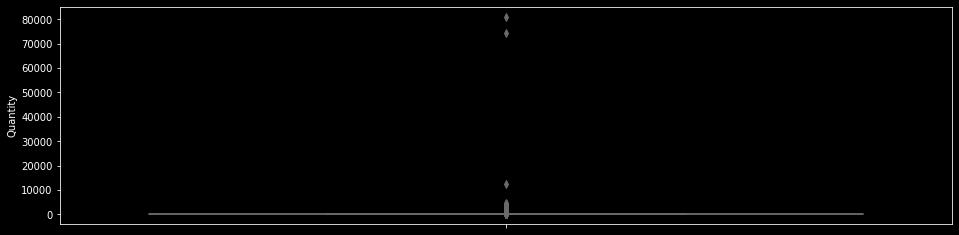

In [64]:
# Boxplot to visualize the Quantity distribution
plt.figure(figsize=(16,4))
sns.boxplot(y='Quantity', data=desc_df, orient='h');

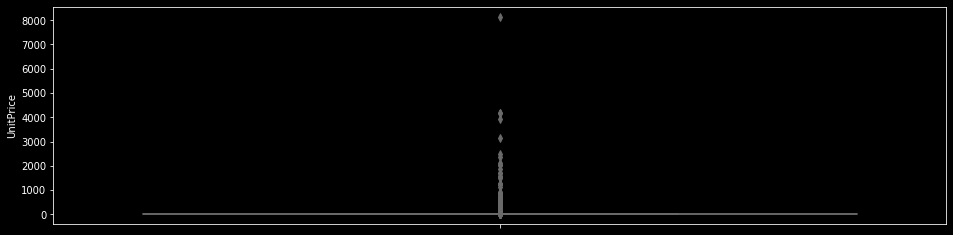

In [63]:
# Let's visualize the Unit price distribution
plt.figure(figsize=(16,4))
sns.boxplot(y='UnitPrice', data=desc_df, orient='h');

In [66]:
# Let's visualize some top products from the whole range.
top_products = desc_df['Description'].value_counts()[:20]

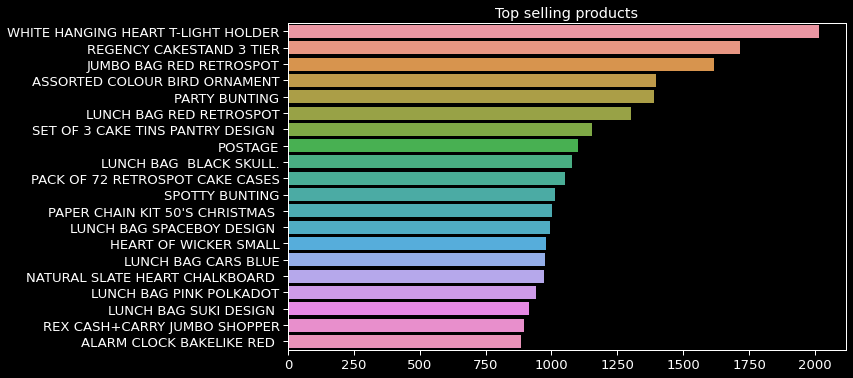

In [67]:
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values)
plt.title("Top selling products")
plt.show();

### Cohort Analysis

**Cohort Analysis**

A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts.

Types of cohorts:
> **Time Cohorts** are customers who signed up for a product or service during a particular time frame. Analyzing these cohorts shows the customers’ behavior depending on the time they started using the company’s products or services. The time may be monthly or quarterly even daily.

> **Behavior cohorts** are customers who purchased a product or subscribed to a service in the past. It groups customers by the type of product or service they signed up. Customers who signed up for basic level services might have different needs than those who signed up for advanced services. Understaning the needs of the various cohorts can help a company design custom-made services or products for particular segments.

> **Size cohorts** refer to the various sizes of customers who purchase company’s products or services. This categorization can be based on the amount of spending in some periodic time after acquisition or the product type that the customer spent most of their order amount in some period of time.

**For cohort analysis, there are a few labels that we have to create:**

**Invoice period** - A string representation of the year and month of a single transaction/invoice.

**Cohort group** - A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.

**Cohort period/Index** -  A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.

In [69]:
## create a copy of rfm_train df for cohort analysis
cohort = rfm_train.copy()

**Assign monthly acquisition cohort**

Defining a cohort is the first step to cohort analysis. We will now create monthly cohorts based on the month each customer has made their first transaction.

In [70]:
## function to parse dates
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [71]:
## Create InvoiceMonth Column
cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month)

In [73]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01


In [74]:
## Group by CustomerID and select InvoiceMonth Value
grouping = cohort.groupby('CustomerID')['InvoiceMonth']

In [76]:
## Assign a minimum InvoiceMonth value to the dataset
cohort['CohortMonth'] = grouping.transform('min')

##### Calculate time offset in months

In [77]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [78]:
invoice_year, invoice_month = get_date_int(cohort, 'InvoiceMonth')

In [80]:
cohort_year, cohort_month = get_date_int(cohort, 'CohortMonth')

In [81]:
years_diff = invoice_year - cohort_year

In [82]:
months_diff = invoice_month - cohort_month

In [83]:
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1

In [84]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
